In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torchvision.datasets as dsets
import torchvision.transforms as transforms

from torch.utils.data import DataLoader

In [65]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)

if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [66]:
x = torch.Tensor(1, 1, 28, 28)

In [57]:
cnn_model = nn.Sequential(nn.Conv2d(1, 32, 3, padding=1),
                          nn.MaxPool2d(2),
                          nn.Conv2d(32, 64, 3, padding=1),
                          nn.MaxPool2d(2))

fc_layer = nn.Sequential(nn.Linear(3136, 64),
                        nn.ReLU(),
                        nn.Dropout(),
                        nn.Linear(64, 32),
                        nn.ReLU(),
                        nn.Linear(32, 10))

In [58]:
out = cnn_model(x)
out = out.view(out.size(0), - 1)

out = fc_layer(out)

### MNIST Training

In [218]:
train_dset = dsets.MNIST('./MNIST_data', train=True, download=False, transform=transforms.ToTensor())
test_dset = dsets.MNIST('./MNIST_data', train=False, download=False, transform=transforms.ToTensor())

In [219]:
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [220]:
type(train_dset)
train_data[0].shape

torch.Size([28, 28])

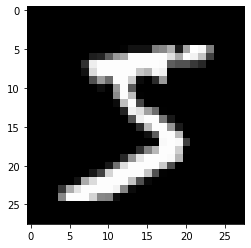

In [221]:
plt.imshow(train_data[0], cmap=plt.cm.gray)

In [222]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True)

In [223]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer_1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),# batch * 28 * 28 * 32
                                        nn.ReLU(),
                                        nn.MaxPool2d(kernel_size=2, stride=2)# batch * 14 * 14 * 32)
                               )
        
        self.layer_2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),# batch * 14 * 14 * 64
                                nn.ReLU(),
                                nn.MaxPool2d(kernel_size=2, stride=2)# batch * 7 * 7 * 64
                               )
                
        self.fc_layer = nn.Linear(7 * 7 * 64, 10)
        
        torch.nn.init.xavier_uniform_(self.fc_layer.weight)
        
    def forward(self, x):
        out = self.layer_1(x)
        out = self.layer_2(out)
        out = out.view(out.size(0), -1) # batch_size * fully_connected(width * height * depth)
        out = self.fc_layer(out)
        
        return out

In [224]:
model = CNN().to(device)

In [225]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [226]:
print(f'전체 배치의 크기: {len(train_loader)}')

전체 배치의 크기: 600


In [240]:
for epoch in range(training_epochs):
    avg_cost = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        prediction = model(x)
        
        loss = criterion(prediction, y)
        
        loss.backward()
        
        optimizer.step()
        
        avg_cost += loss / len(train_loader)
    
    print(f'Epoch: {epoch}, Avg Loss: {avg_cost}')

Epoch: 0, Avg Loss: 0.0054581547155976295
Epoch: 1, Avg Loss: 0.0010749431094154716
Epoch: 2, Avg Loss: 0.00042542265146039426
Epoch: 3, Avg Loss: 0.0020372008439153433
Epoch: 4, Avg Loss: 0.002701005432754755
Epoch: 5, Avg Loss: 0.0020568992476910353
Epoch: 6, Avg Loss: 0.0014301178744062781
Epoch: 7, Avg Loss: 0.002839067718014121
Epoch: 8, Avg Loss: 0.0018604669021442533
Epoch: 9, Avg Loss: 0.0012052253587171435
Epoch: 10, Avg Loss: 0.0017620924627408385
Epoch: 11, Avg Loss: 0.001455016084946692
Epoch: 12, Avg Loss: 0.0009418167173862457
Epoch: 13, Avg Loss: 0.0019011694239452481
Epoch: 14, Avg Loss: 0.0024381487164646387


In [263]:
with torch.no_grad():
    x_test = test_dset.test_data.view(len(test_dset), 1, 28, 28).float().to(device)
    y_test = test_dset.test_labels.to(device)
    
    prediction = model(x_test)
    correct = torch.argmax(prediction, 1) == y_test
    accuracy = correct.float().mean()
    print(accuracy)

tensor(0.9873, device='cuda:0')


### DeepCNN

In [318]:
train_dset = dsets.MNIST('./MNIST_data/', download=False, train=True, transform=transforms.ToTensor())
test_dset = dsets.MNIST('./MNIST_data/', download=False, train=False, transform=transforms.ToTensor())

In [319]:
batch_size = 100
training_epoch = 15
learning_rate = 0.01

In [323]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True, drop_last=True)

In [324]:
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn_layer_1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                         nn.MaxPool2d(kernel_size=2, stride=2)
                                        ) # ? 14 * 14 * 32 
        
        self.cnn_layer_2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                         nn.MaxPool2d(kernel_size=2, stride=2)
                                        ) # ? 7 * 7 * 64
        
        self.cnn_layer_3 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                                        nn.ReLU(),
                                         nn.MaxPool2d(kernel_size=2, stride=2, padding=1)
                                        ) # ? 4 * 4 * 128
        
        self.fc = nn.Linear(4 * 4 * 128, 256)
        torch.nn.init.xavier_uniform_(self.fc.weight)
        
        self.fc_layer_1 = nn.Sequential(self.fc,
                                        nn.ReLU(),
                                        nn.Dropout(0.5))
        self.fc2 = nn.Linear(256, 10)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        
    def forward(self, x):
        out = self.cnn_layer_1(x)
        out = self.cnn_layer_2(out)
        out = self.cnn_layer_3(out)
        
        out = out.view(out.size(0), -1)
        
        out = self.fc_layer_1(out)
        out = self.fc2(out)
        
        return out

In [325]:
model = DeepCNN().to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [326]:
for epoch in range(training_epoch):
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        
        prediction = model(x)
        
        loss = criterion(prediction, y)
        
        loss.backward()
        
        optimizer.step()
        
    print(f'Epoch: {epoch}, Loss:{loss}')

Epoch: 0, Loss:0.14056551456451416
Epoch: 1, Loss:0.11406157165765762
Epoch: 2, Loss:0.07350924611091614
Epoch: 3, Loss:0.11954648792743683
Epoch: 4, Loss:0.20781439542770386
Epoch: 5, Loss:0.14893697202205658
Epoch: 6, Loss:0.04176359623670578
Epoch: 7, Loss:0.17043006420135498
Epoch: 8, Loss:0.3174457848072052
Epoch: 9, Loss:0.07870926707983017
Epoch: 10, Loss:0.06635156273841858
Epoch: 11, Loss:0.18201236426830292
Epoch: 12, Loss:0.021916812285780907
Epoch: 13, Loss:0.0273324865847826
Epoch: 14, Loss:0.040160343050956726


In [327]:
with torch.no_grad():
    x = test_dset.data.view(len(test_dset), 1, 28, 28).float().to(device)
    y = test_dset.targets.to(device)
    
    prediction = model(x)
    
    accuracy = (torch.argmax(prediction, dim=1) == y).float().mean()
    
    print(accuracy)

tensor(0.8031, device='cuda:0')
